In [1]:
import sys
sys.path.append('..')
from scripts.data_analysis import DataAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
original_df = pd.read_csv('../data/data_wave5.csv')

In [3]:
columns_to_extract = [
    'eApoB', 'eHDLC', 'eTotFA', 'eSerumTG', 'eGp', 'eIle', 'sex', 'eage',
    'eauditsc', 'eincom01', 'eauditsc', 'eipmeto2', 'ecidep09', 'eHSCRP', 'eIL6',
    'eIRSsum9', 'ems_waist', 'ems_hpt', 'ems_trig2', 'ems_hdl2', 'ems_gluc2',
    'emet_syn2', 'etri_med', 'ehdl_med', 'esbp_med', 'edbp_med', 'egluc_med'
]

extracted_df = original_df[columns_to_extract]

extracted_csv_file = '../data/wave5_data_to_discretize.csv'
extracted_df.to_csv(extracted_csv_file, index=False)

In [4]:
def classify_data(df):
    """
    Classify each column in a pandas DataFrame as continuous, discrete, binary, or categorical.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to classify.

    Returns:
    dict: A dictionary with column names as keys and their classifications as values.
    """
    def classify_series(series):
        """
        Classify a pandas Series as continuous, discrete, binary, or categorical.
        
        Parameters:
        series (pd.Series): The Series from a column to classify.

        Returns:
        str: The classification of the series ('continuous', 'discrete', 'binary', 'categorical').
        """
        if pd.api.types.is_numeric_dtype(series):
            unique_count = series.nunique()
            total_count = len(series)
            
            if unique_count == 2:
                return 'binary'
            elif unique_count < 10:
                return 'discrete'
            else:
                return 'continuous'
        else:
            return 'categorical'

    column_classifications = {col: classify_series(df[col]) for col in df.columns}
    return column_classifications

In [5]:
data = pd.read_csv('../data/wave5_data_to_discretize.csv')

In [6]:
# replace -1 in columns with NaN
columns_with_minus_one = [
    'eHSCRP', 'eIL6', 'ems_waist', 'ems_hpt', 'ems_trig2', 'ems_hdl2', 'ems_gluc2',
    'emet_syn2'
]
for col in columns_with_minus_one:  
  data[col] = data[col].replace(-1, np.nan)

data['eIRSsum9'] = data[col].replace(-3, np.nan)
data['eIRSsum9'] = data[col].replace(-2, np.nan)

In [7]:
column_types = classify_data(data)
column_types

{'eApoB': 'continuous',
 'eHDLC': 'continuous',
 'eTotFA': 'continuous',
 'eSerumTG': 'continuous',
 'eGp': 'continuous',
 'eIle': 'continuous',
 'sex': 'binary',
 'eage': 'continuous',
 'eauditsc': 'continuous',
 'eincom01': 'continuous',
 'eauditsc.1': 'continuous',
 'eipmeto2': 'continuous',
 'ecidep09': 'binary',
 'eHSCRP': 'continuous',
 'eIL6': 'continuous',
 'eIRSsum9': 'binary',
 'ems_waist': 'binary',
 'ems_hpt': 'binary',
 'ems_trig2': 'binary',
 'ems_hdl2': 'binary',
 'ems_gluc2': 'binary',
 'emet_syn2': 'binary',
 'etri_med': 'continuous',
 'ehdl_med': 'continuous',
 'esbp_med': 'continuous',
 'edbp_med': 'continuous',
 'egluc_med': 'continuous'}

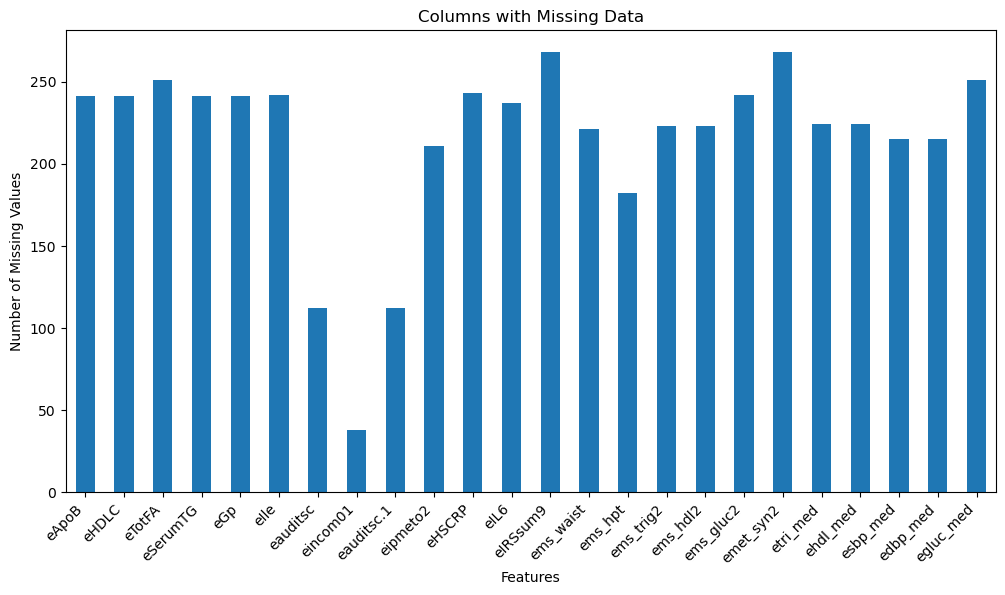

In [8]:
DataAnalysis.plot_missing_values(data)

In [9]:
from scipy.stats import chi2_contingency

def perform_little_mcar_test(df):
    results = []

    for col_with_missing_data in df.columns[df.isnull().any()]:
        # Create a mask indicating where data is missing
        missing_data = df[col_with_missing_data ].isnull().astype(int)

        # Create contingency table for Chi-Squared test
        contingency_table = pd.crosstab(missing_data, df.drop(columns=[col_with_missing_data]).isnull().any(axis=1).astype(int))

        # Perform Chi-Squared test
        chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table, correction=False)

        # Append results
        results.append({'Column': col_with_missing_data, 'Chi-Squared': chi2_stat, 'df': dof, 'p-value': p_val})

    return pd.DataFrame(results)

perform_little_mcar_test(data)

,Column,Chi-Squared,df,p-value
0,eApoB,830.941795,1,1.011382e-182
1,eHDLC,830.941795,1,1.011382e-182
2,eTotFA,820.617940,1,1.775908e-180
3,eSerumTG,830.941795,1,1.011382e-182
4,eGp,830.941795,1,1.011382e-182
5,eIle,834.803982,1,1.463012e-183
6,eauditsc,362.929152,1,6.483010e-81
7,eincom01,12.074830,1,5.110713e-04
8,eauditsc.1,362.929152,1,6.483010e-81
9,eipmeto2,246.772493,1,1.312452e-55


Data is not missing completely at random so we cannot discard it

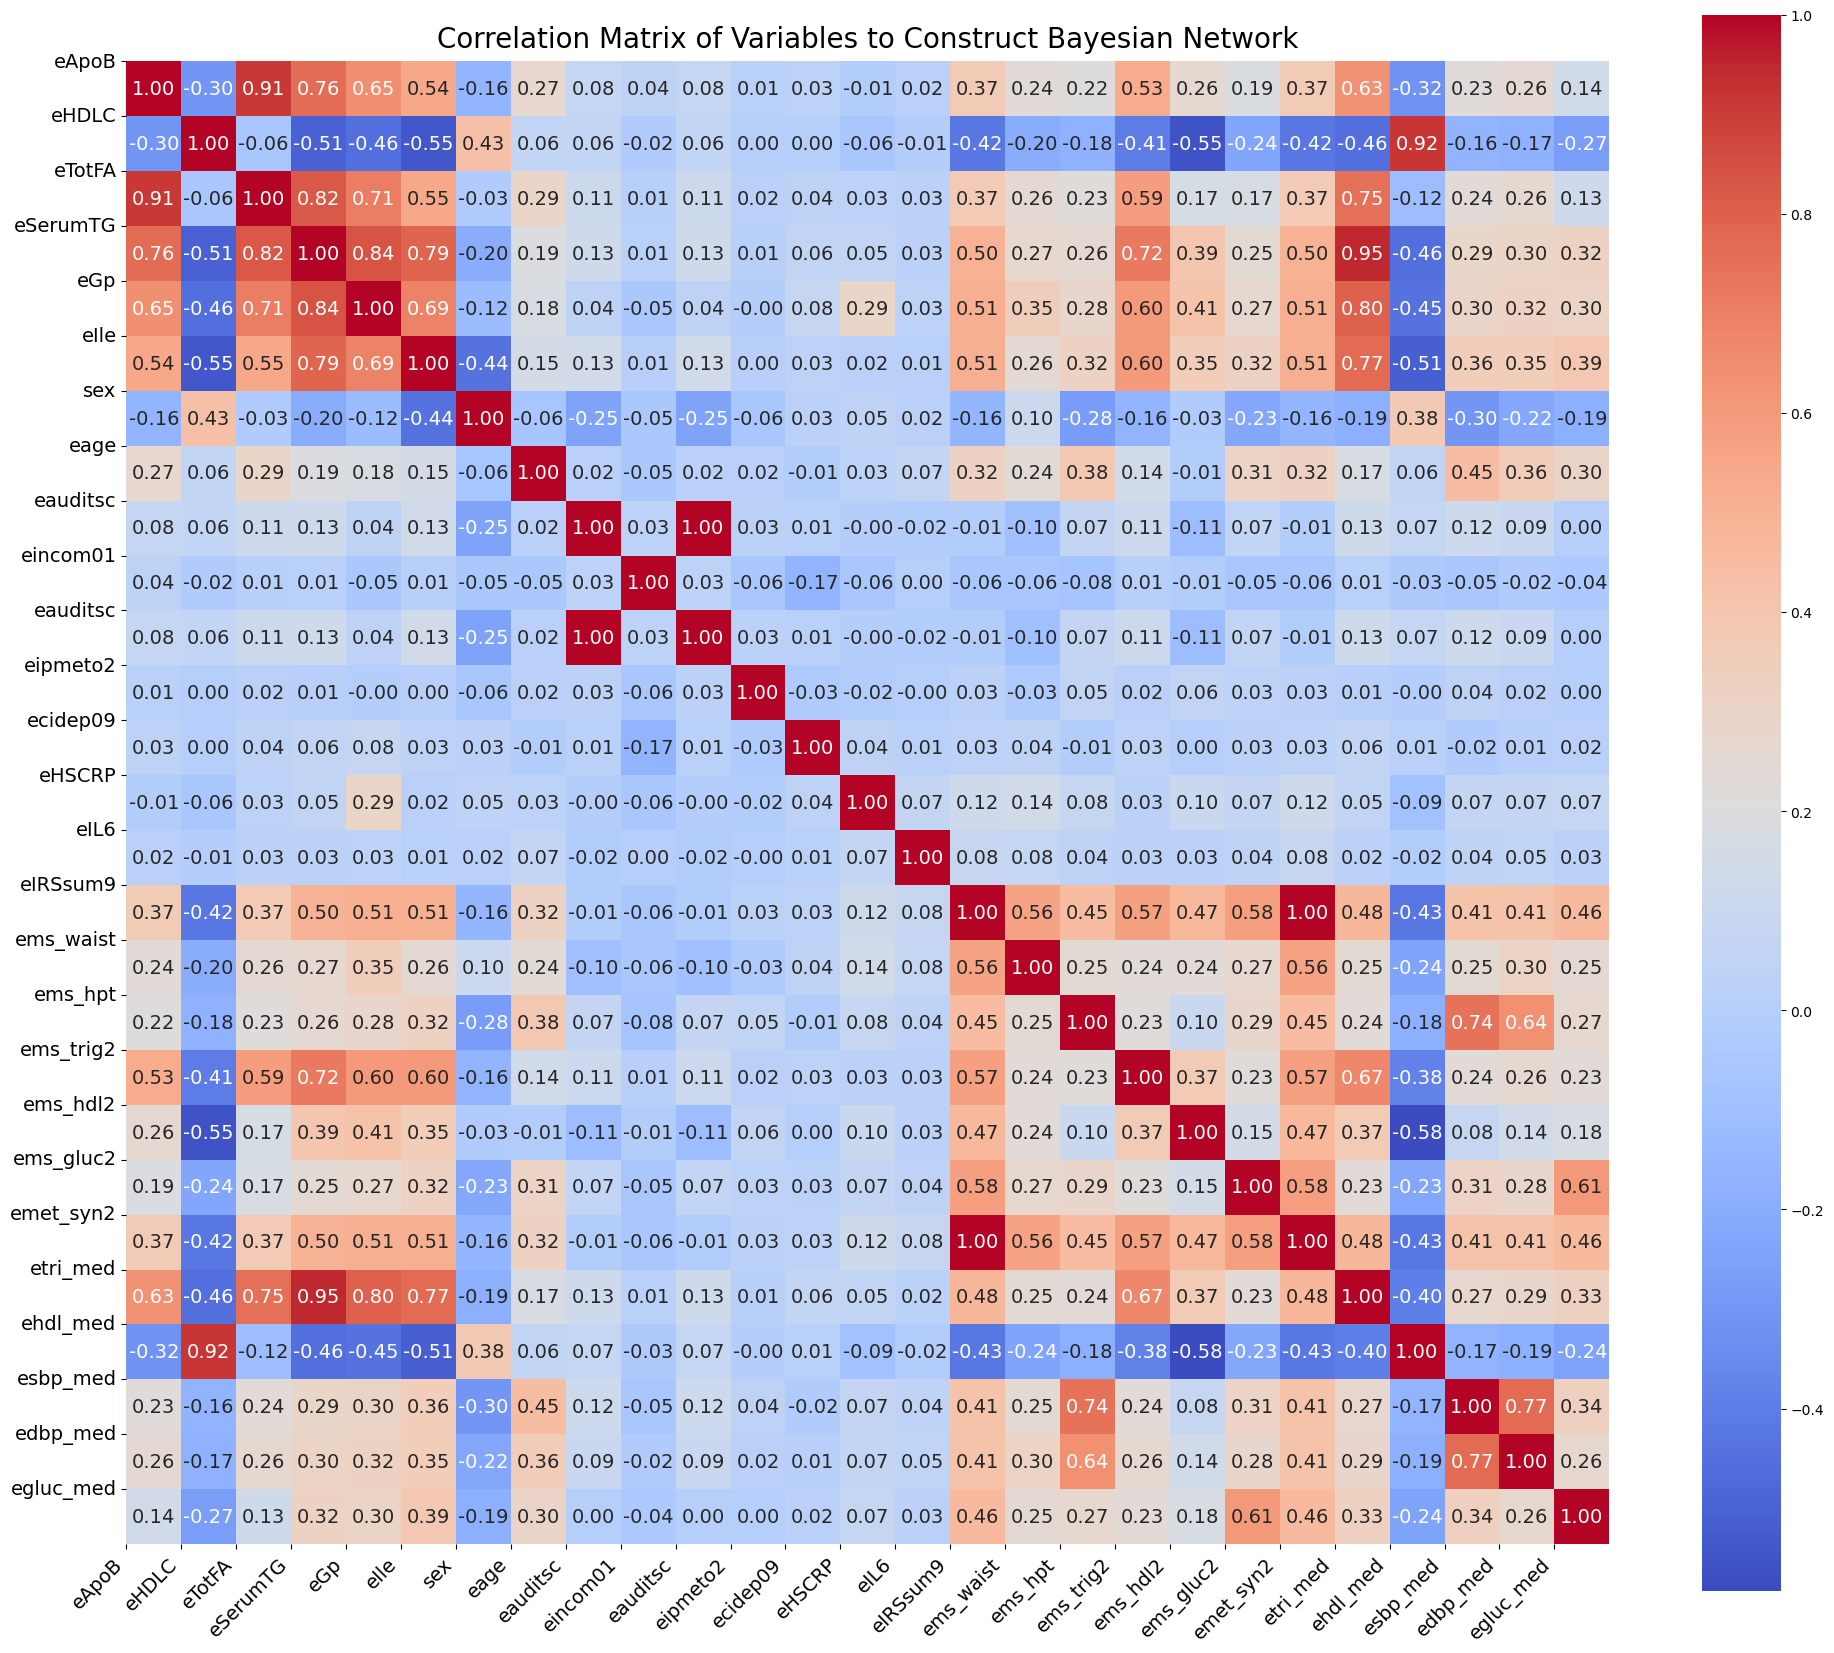

In [10]:
DataAnalysis.plot_correlation_matrix(data, columns_to_extract, 'Variables to Construct Bayesian Network')

Now, we are going to determine the imputation strategy for each column with missing data based on correlation matrix

In [11]:
corr_matrix = data.corr().abs()

In [12]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def impute_missing_values(df, corr_matrix, column_types):
    imputed_df = df.copy()

    if 'emet_syn2' in df.columns:
        correlated_vars = ['ems_trig2', 'ems_hdl2', 'ems_hpt', 'ems_gluc2', 'etri_med', 'ehdl_med', 'esbp_med', 'edbp_med', 'egluc_med']
        imputation_vars = ['emet_syn2'] + correlated_vars
        data_for_imputation = df[imputation_vars]
        
        iter_imputer = IterativeImputer(max_iter=100, random_state=42)
        imputed_data = iter_imputer.fit_transform(data_for_imputation)
        # convert to binary
        imputed_df['emet_syn2'] = np.round(imputed_data[:, 0]).astype(int)

    for col in df.columns[df.isnull().any()]:
        if col == 'emet_syn2':
            continue

        col_corr = corr_matrix[col].drop(col)
        max_corr = col_corr.max()

        # use MICE for highly correlated columns
        if max_corr > 0.6:
            mice_imputer = IterativeImputer(random_state=42)
            imputed_df[col] = mice_imputer.fit_transform(df[[col] + col_corr.index.tolist()])[:, 0]
        # use kNN for everything else
        else:
            knn_imputer = KNNImputer(n_neighbors=10)
            imputed_df[col] = knn_imputer.fit_transform(df[[col] + col_corr.index.tolist()])[:, 0]
        
        if column_types[col] == 'binary':
            imputed_df[col] = np.round(imputed_df[col]).astype(int)

    return imputed_df

In [13]:
imputed_df = impute_missing_values(data, corr_matrix, column_types)

In [14]:
DataAnalysis.plot_missing_values(imputed_df)

No missing values


In [15]:
classify_data(imputed_df)

{'eApoB': 'continuous',
 'eHDLC': 'continuous',
 'eTotFA': 'continuous',
 'eSerumTG': 'continuous',
 'eGp': 'continuous',
 'eIle': 'continuous',
 'sex': 'binary',
 'eage': 'continuous',
 'eauditsc': 'continuous',
 'eincom01': 'continuous',
 'eauditsc.1': 'continuous',
 'eipmeto2': 'continuous',
 'ecidep09': 'binary',
 'eHSCRP': 'continuous',
 'eIL6': 'continuous',
 'eIRSsum9': 'binary',
 'ems_waist': 'binary',
 'ems_hpt': 'binary',
 'ems_trig2': 'binary',
 'ems_hdl2': 'binary',
 'ems_gluc2': 'binary',
 'emet_syn2': 'binary',
 'etri_med': 'continuous',
 'ehdl_med': 'continuous',
 'esbp_med': 'continuous',
 'edbp_med': 'continuous',
 'egluc_med': 'continuous'}

In [16]:
imputed_df.to_csv('../data/network/imputed_data_wave5.csv')

## Transform continuous variables to discrete

In [17]:
preprocessed_df = pd.read_csv('../data/network/imputed_data_wave5.csv')

In [18]:
from sklearn.cluster import KMeans
def apply_kmeans(df, column_name, n_clusters=3, random_state=0):
    data = df[column_name].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data)
    
    # get centroids and create sorted labels
    centroids = kmeans.cluster_centers_
    sorted_idx = np.argsort(centroids.ravel())
    labels_sorted = ['Low', 'Moderate', 'High']
    
    # map original cluster labels to meaningful labels
    cluster_mapping = {old_label: new_label for old_label, new_label in zip(sorted_idx, labels_sorted)}
    df[column_name] = kmeans.labels_
    df[column_name] = df[column_name].map(cluster_mapping)
    
    # visualize
    colors = ['#3B28CC', '#3F8EFC', '#ADD7F6']
    plt.figure(figsize=(8, 6))
    for label in labels_sorted:
        subset = df[df[column_name] == label]
        plt.hist(subset[column_name], bins=np.arange(n_clusters + 1) - 0.5, color=colors[labels_sorted.index(label)], label=label, alpha=0.75, edgecolor='black')

    plt.title(f'Clusters of {column_name}')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(range(n_clusters), labels_sorted) 
    plt.legend()
    plt.show()
    
    return df

In [19]:
#eApoB
bins = [-float('inf'), 1.3, float('inf')]
labels = ['Low', 'High']
preprocessed_df['eApoB'] = pd.cut(preprocessed_df['eApoB'], bins=bins, labels=labels, right=False)
preprocessed_df['eApoB'].unique()

['Low', 'High']
Categories (2, object): ['Low' < 'High']

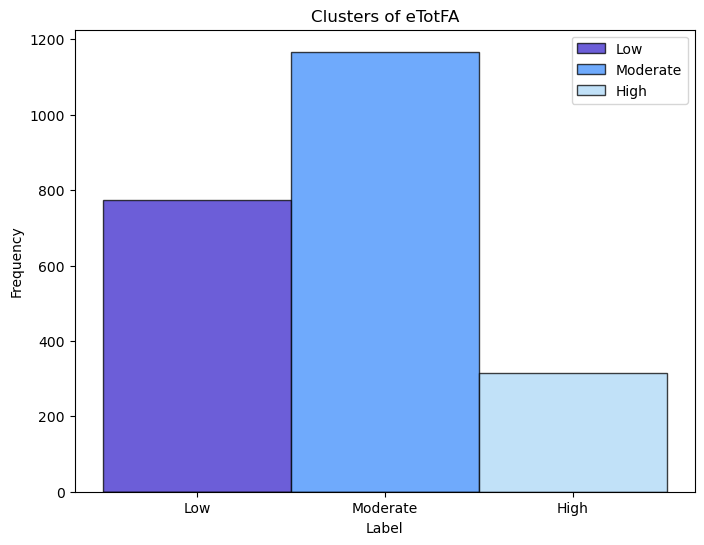

In [20]:
#eTotFA
preprocessed_df = apply_kmeans(preprocessed_df, 'eTotFA', n_clusters=3, random_state=0)

In [21]:
preprocessed_df['eHDLC'] = preprocessed_df.apply(
    lambda row: 'Desirable' if (row['sex'] == 1 and row['eHDLC'] > 1.03) or (row['sex'] == 2 and row['eHDLC'] > 1.29) else 'At risk',
    axis=1
)

In [22]:
bins = [-float('inf'), 1.69, 2.26, 5.65, float('inf')]
labels = ['Desirable', 'Mild Hypertriglyceridemia', 'High Hypertriglyceridemia', 'Very High Hypertriglyceridemia']
preprocessed_df['eSerumTG'] = pd.cut(preprocessed_df['eSerumTG'], bins=bins, labels=labels)
preprocessed_df['eSerumTG'].unique()

['Desirable', 'Mild Hypertriglyceridemia', 'High Hypertriglyceridemia', 'Very High Hypertriglyceridemia']
Categories (4, object): ['Desirable' < 'Mild Hypertriglyceridemia' < 'High Hypertriglyceridemia' < 'Very High Hypertriglyceridemia']

In [23]:
preprocessed_df['eGp'] = preprocessed_df['eGp'].apply(lambda x: 'Normal' if x <= 1.2 else 'At risk')
preprocessed_df['eGp'].unique()

array(['At risk', 'Normal'], dtype=object)

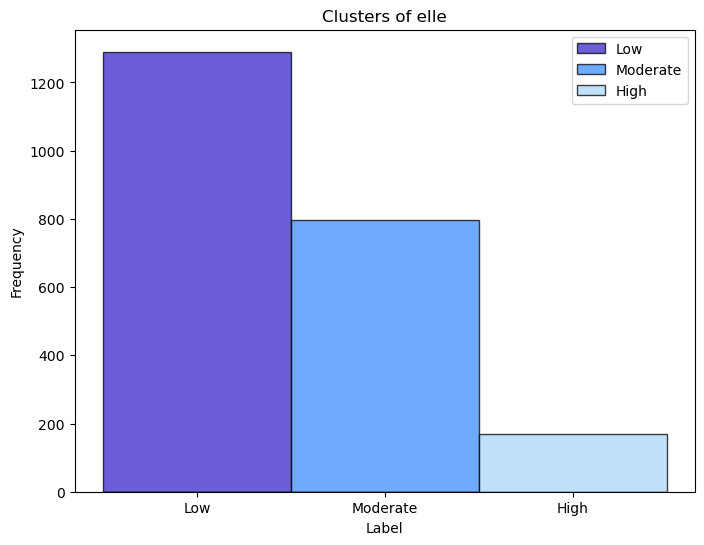

In [24]:
preprocessed_df = apply_kmeans(preprocessed_df, 'eIle', n_clusters=3, random_state=0)

In [25]:
def categorize_met(met):
    moderate = 4.9 * 60 * 3 # assuming 3 sessions of 1 hour each per week
    vigorous = 6.8 * 60 * 3
    if met >= moderate and met < vigorous:  
        return 'Moderate'
    elif met >= 6.8 * 60 * 3: 
        return 'Vigorous'
    else:
        return 'Low'

preprocessed_df['eipmeto2'] = preprocessed_df['eipmeto2'].apply(categorize_met)
print(preprocessed_df['eipmeto2'].value_counts())

Vigorous    1880
Low          263
Moderate     113
Name: eipmeto2, dtype: int64


In [27]:
preprocessed_df['eIL6'] = pd.cut(preprocessed_df['eIL6'],
                                bins=[-float('inf'), 7, float('inf')],
                                labels=['Normal', 'High'],
                                right=True) 

print(preprocessed_df['eIL6'].value_counts())

Normal    2203
High        53
Name: eIL6, dtype: int64


In [29]:
preprocessed_df['eHSCRP'] = pd.cut(preprocessed_df['eHSCRP'],
                                  bins=[-float('inf'), 0.3, 1, 10, 50, float('inf')],
                                  labels=['Normal', 'Minor', 'Moderate', 'Marked', 'Severe'],
                                  right=False)
print(preprocessed_df['eHSCRP'].value_counts())

Moderate    1257
Minor        668
Normal       247
Marked        81
Severe         3
Name: eHSCRP, dtype: int64


In [31]:
def categorize_atri_med(row):
    adult_threshold = 150 * 0.01129  # mg/dL to mmol/L for adults
    child_threshold = 90 * 0.01129   # mg/dL to mmol/L for children and teens

    if row['eage'] > 19:
        if row['etri_med'] < adult_threshold:
            return 'Healthy'
        else:
            return 'High'
    else: 
        if row['etri_med'] < child_threshold:
            return 'Healthy'
        else:
            return 'High'

preprocessed_df['etri_med'] = preprocessed_df.apply(categorize_atri_med, axis=1)
print(preprocessed_df['etri_med'].value_counts())

Healthy    1820
High        436
Name: etri_med, dtype: int64


In [32]:
def categorize_ahdl_med(row):
    if row['sex'] == 1: 
        return 'Healthy' if row['ehdl_med'] > 1.0 else 'Unhealthy'
    elif row['sex'] == 2: 
        return 'Healthy' if row['ehdl_med'] > 1.2 else 'Unhealthy'

preprocessed_df['ehdl_med'] = preprocessed_df.apply(categorize_ahdl_med, axis=1)
preprocessed_df['ehdl_med'].value_counts()

Healthy      1935
Unhealthy     321
Name: ehdl_med, dtype: int64

In [33]:
def categorize_blood_pressure(df):
    for index, row in df.iterrows():
        sbp = row['esbp_med']
        dbp = row['edbp_med']
        
        if sbp < 122 and dbp < 80:
            df.at[index, 'esbp_med'] = 'Normal'
            df.at[index, 'edbp_med'] = 'Normal'
        elif 120 <= sbp <= 129 and dbp < 80:
            df.at[index, 'esbp_med'] = 'Elevated'
            df.at[index, 'edbp_med'] = 'Elevated'
        elif (130 <= sbp <= 139 or 80 <= dbp <= 89):
            df.at[index, 'esbp_med'] = 'Hypertension I'
            df.at[index, 'edbp_med'] = 'Hypertension I'
        elif sbp >= 140 or dbp >= 90:
            df.at[index, 'esbp_med'] = 'Hypertension II'
            df.at[index, 'edbp_med'] = 'Hypertension II'
        else:
            df.at[index, 'esbp_med'] = 'Uncategorized'
            df.at[index, 'edbp_med'] = 'Uncategorized'

categorize_blood_pressure(preprocessed_df)

In [34]:
def categorize_glucose_level(glucose_mmol):
    glucose_mg_dl = glucose_mmol * 18  # convert mmol/L to mg/dL
    if glucose_mg_dl < 70:
        return 'Hypoglycemia'
    elif 70 <= glucose_mg_dl <= 100:
        return 'Normal'
    elif 100 < glucose_mg_dl <= 125:
        return 'Prediabetes'
    elif glucose_mg_dl >= 126:
        return 'Diabetes'
    else:
        return 'Uncategorized' 

preprocessed_df['egluc_med'] = preprocessed_df['egluc_med'].apply(categorize_glucose_level)

preprocessed_df['egluc_med'].value_counts()

Normal          1434
Prediabetes      678
Diabetes         141
Hypoglycemia       3
Name: egluc_med, dtype: int64

In [35]:
# save data to build the network
preprocessed_df.to_csv('../data/network/final_data_wave5.csv', index=False)

In [36]:
final_data = pd.read_csv('../data/network/final_data_wave5.csv')
classify_data(final_data)

{'Unnamed: 0': 'continuous',
 'eApoB': 'categorical',
 'eHDLC': 'categorical',
 'eTotFA': 'categorical',
 'eSerumTG': 'categorical',
 'eGp': 'categorical',
 'eIle': 'categorical',
 'sex': 'binary',
 'eage': 'continuous',
 'eauditsc': 'continuous',
 'eincom01': 'continuous',
 'eauditsc.1': 'continuous',
 'eipmeto2': 'categorical',
 'ecidep09': 'binary',
 'eHSCRP': 'categorical',
 'eIL6': 'categorical',
 'eIRSsum9': 'binary',
 'ems_waist': 'binary',
 'ems_hpt': 'binary',
 'ems_trig2': 'binary',
 'ems_hdl2': 'binary',
 'ems_gluc2': 'binary',
 'emet_syn2': 'binary',
 'etri_med': 'categorical',
 'ehdl_med': 'categorical',
 'esbp_med': 'categorical',
 'edbp_med': 'categorical',
 'egluc_med': 'categorical'}